In [25]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
from skimage.io import imread
from skimage.transform import resize
import dill

DATA_PATH = "NU_data/"
TEST_PATH = DATA_PATH+"stage1_test/"
HEIGHT = 128
WIDTH = 128
cases = os.listdir(TEST_PATH)

try:
    dill.load_session('notebook2_env.db')
    print ("读取环境变量")
except:
    print ("环境变量文件没找到")

读取环境变量


In [14]:
#prepare the data
images = np.zeros((len(cases),HEIGHT, WIDTH,3), dtype=np.uint8)

print('Getting and resizing TEST images and masks ... ')

for c_i, c in tqdm(enumerate(cases), total=len(cases)):
    #get and resize image
    img = imread(TEST_PATH+"{}/images/{}.png".format(c,c))[:, :, :3]
    img = resize(img, (HEIGHT, WIDTH, 3), mode='constant', preserve_range=True)
    images[c_i] =img

print('Done!')
print(len(images))

dill.dump_session('notebook2_env.db')

Getting and resizing TEST images and masks ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 80.11it/s]


Done!
65


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config = config) as sess:
    #20180423133753 
    #20180425203226

    # Restore variables from disk.
    #module_file = tf.train.latest_checkpoint('tmp/')
    module_file = 'NU_model/20180425203226'
    saver = tf.train.import_meta_graph(module_file+'.meta')
    saver.restore(sess, module_file)
    print ("Model loaded.")
    
    graph = tf.get_default_graph()
    x_ = tf.get_collection('x_')[0]
    train_mode = tf.get_collection('train_mode')[0]
    loss = tf.get_collection('loss')[0]   
    preds = tf.get_collection('preds')[0]   
    test_images = images/255
    
    prd = sess.run(
        preds,
        feed_dict={x_: test_images, train_mode: False}
    )
    print ("done!")

INFO:tensorflow:Restoring parameters from NU_model/20180425203226
Model loaded.
done!


100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 166.12it/s]


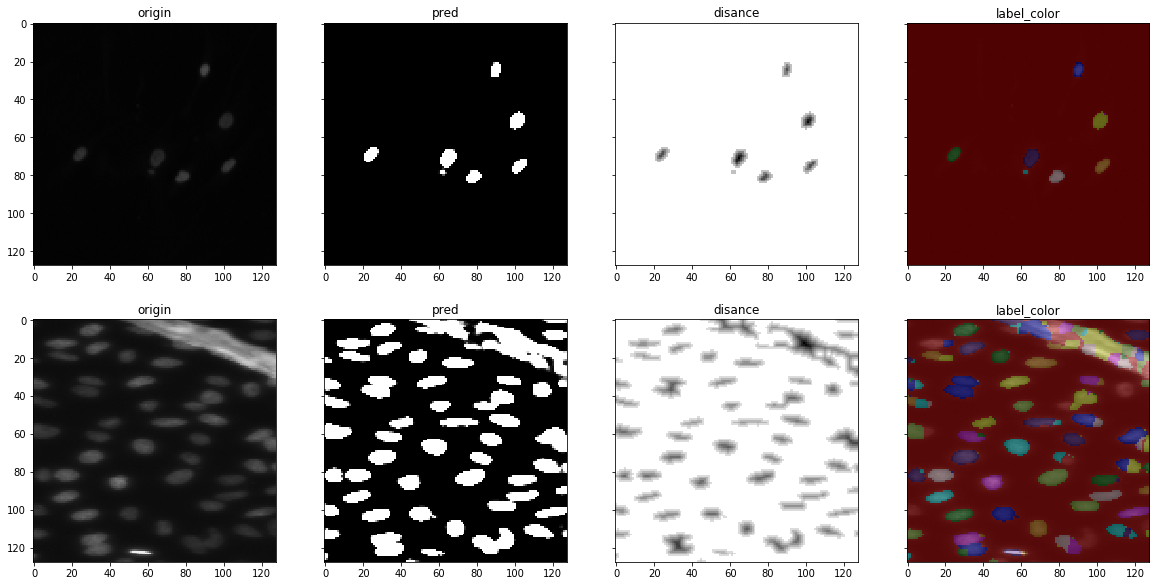

In [49]:
from skimage import measure, morphology, color
import matplotlib.patches as mpatches
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

distance = np.zeros((len(prd),HEIGHT, WIDTH), dtype = np.float32)
label = np.zeros((len(prd),HEIGHT, WIDTH), dtype = np.float32)
label_c = np.zeros((len(prd),HEIGHT, WIDTH,3), dtype = np.float32)

for i, p in tqdm(enumerate (prd), total = len(prd) ):
    #转化为bool型
    binary =  np.array(p[:,:,0] > 0.5, dtype = np.bool)
    #删除小区域
    rso = morphology.remove_small_objects(binary,min_size=5,connectivity=1)
    #生成距离图
    distance[i] = ndi.distance_transform_edt(rso)
    
    local_max = peak_local_max(distance[i], indices=False, footprint=np.ones((2, 2)), labels=rso)
    markers = ndi.label(local_max)[0]
    label[i] = morphology.watershed(-distance[i], markers, mask=rso)
    
    label_c[i]=color.label2rgb(label[i], image=test_images[i])

arr = range(0,2)
fig,axs = plt.subplots(len(arr), 4, figsize=(20, num*5),sharey = True)
axs=axs.ravel()
for i in arr:
    itr = (i-arr[0]) * 4
    axs[itr].imshow(test_images[i],cmap='hot')
    axs[itr].set_title('origin')
    
    axs[itr+1].imshow(prd[i][:,:,0],cmap="gray")
    axs[itr+1].set_title('pred')   
    
    axs[itr+2].imshow(-distance[i], cmap="gray")
    axs[itr+2].set_title('disance')
    
    axs[itr+3].imshow(label_c[i])
    axs[itr+3].set_title('label_color')


In [66]:
def rle_encoding(x):
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    #lab_img = morphology.label(x>cut_off)
    #if lab_img.max()<1:
        #lab_imgs[:,:] = 1 # ensure at least one prediction per image
    for i in range(1, x.max()+1):
        yield rle_encoding(x==i)

In [68]:
rles = []
new_test_ids = []

for i, case in enumerate(cases):
    #pass
    rle = list(prob_to_rles(label[i]))
    rles.extend(rle)
    new_test_ids.extend([case] * len(rle))

csv = pd.DataFrame()
csv['ImageId'] = new_test_ids
csv['EncodedPixels'] = rles
csv.EncodedPixels.map(lambda x: ' '.join(str(s) for s in x))

csv.head(100)

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[11288, 6, 11414, 8, 11542, 8, 11670, 8, 11799..."
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[12595, 6, 12722, 7, 12849, 9, 12977, 8, 13104..."
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[2758, 4, 2885, 6, 3012, 7, 3139, 7, 3267, 7, ..."
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[7880, 4, 8006, 7, 8133, 9, 8260, 10, 8388, 10..."
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[12749, 3, 12875, 6, 13002, 7, 13130, 6, 13257..."
5,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[7887, 2, 8015, 2, 8143, 2]"
6,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[9682, 3, 9809, 5, 9935, 7, 10063, 7, 10191, 7..."
7,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,"[5761, 1, 5889, 1, 6017, 1, 6145, 1, 6150, 1, ..."
8,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,"[9486, 2, 9613, 4, 9742, 3, 9870, 3, 9998, 3, ..."
9,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,"[3079, 1, 3206, 4, 3333, 5, 3460, 6, 3588, 6, ..."
